In [327]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
from tabulate import tabulate
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [361]:
# Download Intel data from Yahoo Finance
intc_data = yf.download("INTC", start="2005-01-01", end="2025-1-1", interval="1wk")
intc_data.tail(10)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,INTC,INTC,INTC,INTC,INTC
Date,,,,,
2024-10-26,23.200001,23.580000,21.469999,22.670000,462235000
2024-11-02,26.200001,26.430000,22.000000,22.959999,438447400
2024-11-09,24.350000,26.290001,23.889999,25.959999,305284000
2024-11-16,24.500000,25.020000,23.549999,24.330000,266762800
2024-11-23,24.049999,25.570000,23.059999,25.040001,251351100
2024-11-30,20.920000,25.480000,20.660000,24.840000,639840000
2024-12-07,20.340000,21.059999,19.870001,20.920000,366831400
2024-12-14,19.520000,21.100000,18.900000,20.170000,389212800


Ticker           INTC
Date                 
2005-01-01  13.178848
2005-01-08  13.306022
2005-01-15  12.959203
2005-01-22  12.855157
2005-01-29  13.294451
...               ...
2024-11-30  20.920000
2024-12-07  20.340000
2024-12-14  19.520000
2024-12-21  20.299999
2024-12-28  20.049999

[1044 rows x 1 columns]


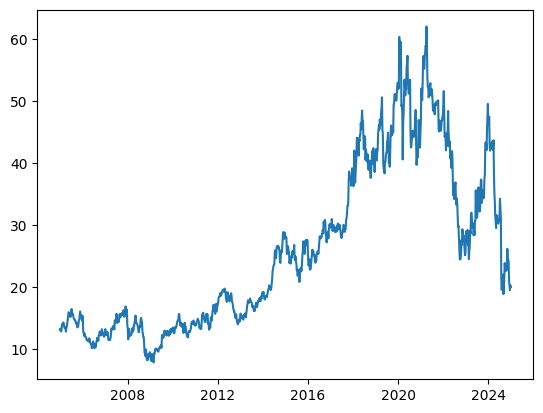

In [329]:
print(price_series)
plt.plot(price_series)
plt.show()

ADF Statistic for prices: -1.516449
p-value for prices: 0.525359
ADF Statistic for returns: -32.735561
p-value for returns: 0.000000


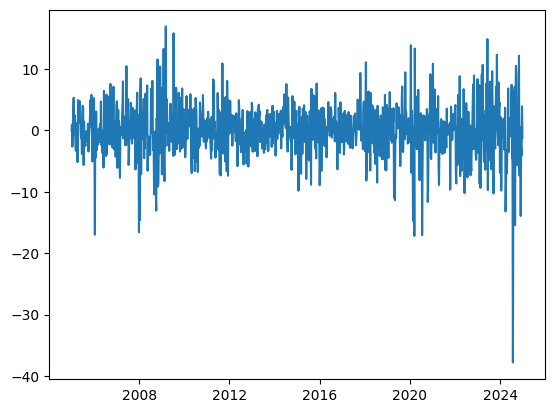

In [330]:
# Use 'Adj Close' if available; otherwise, fall back to 'Close'
if 'Adj Close' in intc_data.columns:
    price_series = intc_data['Adj Close']
else:
    price_series = intc_data['Close']

price_series = price_series.dropna()

# apply ADF test
from statsmodels.tsa.stattools import adfuller
result = adfuller(price_series)
print('ADF Statistic for prices: %f' % result[0])
print('p-value for prices: %f' % result[1])

# Compute log returns
#first_val = np.log(price_series.iloc[0])
returns = 100*np.log(price_series).diff().fillna(0)
#returns = np.diff(np.log(price_series), prepend=first_val[0], axis=0)

plt.plot(returns)

result = adfuller(returns)
print('ADF Statistic for returns: %f' % result[0])
print('p-value for returns: %f' % result[1])

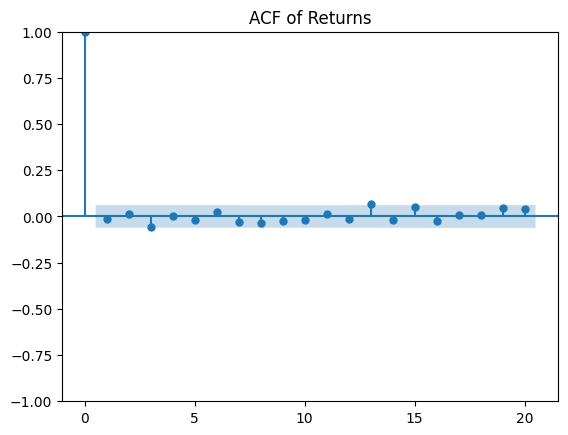

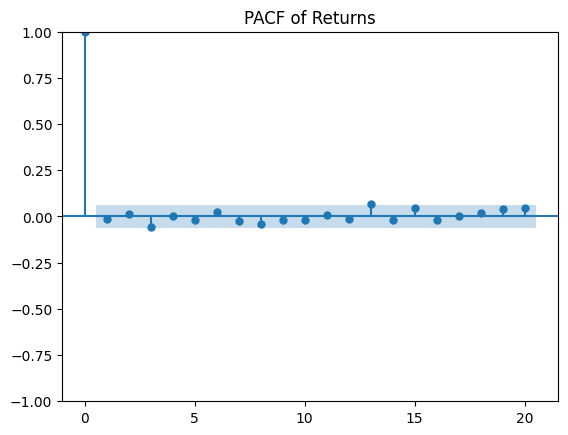

In [331]:
plot_acf(returns, lags=20, title='ACF of Returns')
plot_pacf(returns, lags=20, title='PACF of Returns')
plt.show()

In [332]:
# no returns ACF or PACF show significant autocorrelation so we can assume returns are white noise
# hence mean model for GARCH is just a constant

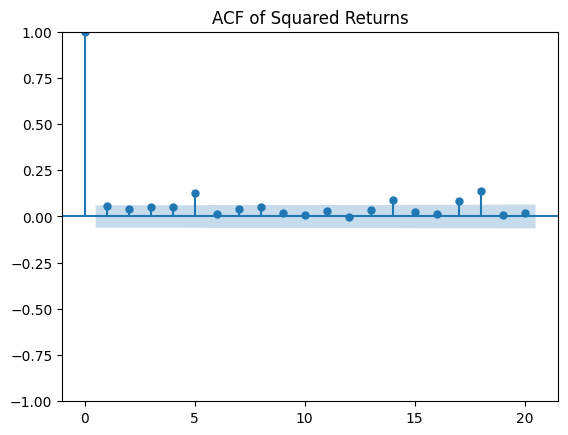

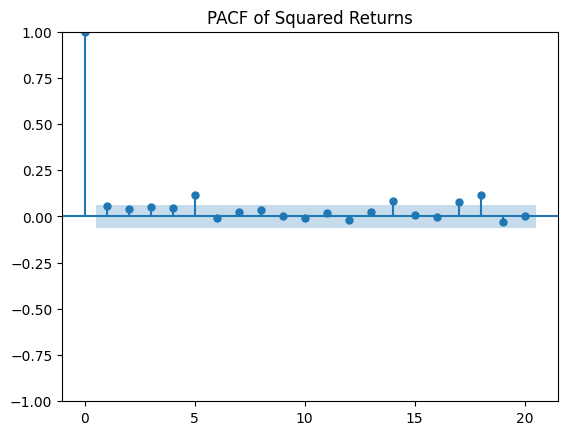

In [333]:


plot_acf(returns**2, lags=20, title='ACF of Squared Returns')
plot_pacf(returns**2, lags=20, title='PACF of Squared Returns')
plt.show()

In [334]:
# ACF and PACF of squared returns show significant autocorrelation at some lags - some ARCH effect
# hence we can use GARCH model

In [335]:
# Define grids for model parameters
mean_models = ['Constant', 'AR']
vol_models = ['GARCH', 'EGARCH']
dists = ['normal', 't']

results = []

for mean in mean_models:
    for vol in vol_models:
        for dist in dists:
            print(f"Fitting model with mean: {mean}, vol: {vol}, dist: {dist}")
            lags = 1 if mean == 'AR' else 0
            
            # -----------------------------
            # Fit the full model on the complete dataset
            model = arch_model(returns, mean=mean, lags=lags, vol=vol, p=1, q=1, dist=dist)
            res = model.fit(disp='off')
            # Extract the conditional volatility values
            cond_vol = res.conditional_volatility

            # -----------------------------
            # Get the AIC from the model
            aic = res.aic
            results.append({'mean': mean, 'vol': vol, 'dist': dist, 'aic': aic})
                

Fitting model with mean: Constant, vol: GARCH, dist: normal
Fitting model with mean: Constant, vol: GARCH, dist: t
Fitting model with mean: Constant, vol: EGARCH, dist: normal
Fitting model with mean: Constant, vol: EGARCH, dist: t
Fitting model with mean: AR, vol: GARCH, dist: normal
Fitting model with mean: AR, vol: GARCH, dist: t
Fitting model with mean: AR, vol: EGARCH, dist: normal
Fitting model with mean: AR, vol: EGARCH, dist: t


In [336]:
#### ONLY FOR TESTING

# Define grids for model parameters
mean_models = ['Constant', 'AR']
vol_models = ['GARCH', 'EGARCH']
dists = ['normal', 't']

results = []
 
np.random.seed(42)

for mean in mean_models:
    for vol in vol_models:
        for dist in dists:
            print(f"Fitting model with mean: {mean}, vol: {vol}, dist: {dist}")
            lags = 1 if mean == 'AR' else 0
            
            # -----------------------------
            # Fit the full model on the complete dataset
            try:
                model_full = arch_model(returns, mean=mean, lags=lags, vol=vol, p=1, q=1, dist=dist)
                res_full = model_full.fit(disp='off')
                # Extract the last 5 in-sample estimated conditional volatility values as a list
                last5_cond_vol = res_full.conditional_volatility.iloc[-5:].tolist()
                # Use the 5th from last estimated volatility as the "actual sigma"
                actual_sigma_1step = res_full.conditional_volatility.iloc[-5]
                actual_sigma_5steps = res_full.conditional_volatility.iloc[-1]
            except Exception as e:
                last5_cond_vol = f"Error: {e}"
                actual_sigma_1step = None
                actual_sigma_5steps = None

            # -----------------------------
            # Fit the model on the training dataset (excluding the last 5 observations)
            try:
                train_returns = returns.iloc[:-5]
                model_train = arch_model(train_returns, mean=mean, lags=lags, vol=vol, p=1, q=1, dist=dist)
                res_train = model_train.fit(disp='off')
                # For EGARCH, use simulation-based forecasting (analytic forecasts for horizon > 1 are not available)
                if vol == 'EGARCH':
                    forecast_train = res_train.forecast(horizon=5, method='simulation', simulations=500, reindex=False)
                else:
                    forecast_train = res_train.forecast(horizon=5, reindex=False)
                # The forecasted variance for each horizon is in an array;
                # take the square root to obtain forecasted volatility for each day.
                vol_forecast_train = np.sqrt(forecast_train.variance.values[-1, :])
                # Take the 5-step ahead forecast (i.e. last element) as the forecast sigma
                forecast_sigma_5steps = vol_forecast_train[-1]
                forecast_sigma_1step = vol_forecast_train[0]
            except Exception as e:
                forecast_sigma_1step = f"Error: {e}"
                forecast_sigma_5steps = f"Error: {e}"

            # -----------------------------
            # Compute the forecast error as the absolute difference between the actual sigma and the forecast sigma
            try:
                if isinstance(actual_sigma_5steps, (float, np.float64)) and isinstance(forecast_sigma_5steps, (float, np.float64)):
                    forecast_error_5steps = abs(actual_sigma_5steps - forecast_sigma_5steps)/actual_sigma_5steps
                else:
                    forecast_error_5steps = None
            except Exception as e:
                forecast_error_5steps = f"Error: {e}"
            # -----------------------------
            # Compute the forecast error as the absolute difference between the actual sigma and the forecast sigma
            try:
                if isinstance(actual_sigma_1step, (float, np.float64)) and isinstance(forecast_sigma_1step, (float, np.float64)):
                    forecast_error_1step = abs(actual_sigma_1step - forecast_sigma_1step)/actual_sigma_1step
                else:
                    forecast_error_1step = None
            except Exception as e:
                forecast_error_1step = f"Error: {e}"
            

            # Collect the results in a dictionary
            results.append({
                "Mean": mean,
                "Volatility": vol,
                "Distribution": dist,
                #"Last 5 Cond Vol": last5_cond_vol,
                "Actual sigma 1 step (from full)": actual_sigma_1step,
                "Forecast sigma 1 step (from train)": forecast_sigma_1step,
                "Forecast Error 1 step": forecast_error_1step,
                "Actual sigma 5 steps (from full)": actual_sigma_5steps,
                "Forecast sigma 5 steps (from train)": forecast_sigma_5steps,
                "Forecast Error 5 steps": forecast_error_5steps,
                "AIC": res_train.aic
            })

# Create a DataFrame to hold the results
results_df = pd.DataFrame(results)

# Print the results as a formatted table using tabulate
print(tabulate(results_df, headers='keys', tablefmt='psql', showindex=False, floatfmt='.4f'))

Fitting model with mean: Constant, vol: GARCH, dist: normal
Fitting model with mean: Constant, vol: GARCH, dist: t
Fitting model with mean: Constant, vol: EGARCH, dist: normal
Fitting model with mean: Constant, vol: EGARCH, dist: t
Fitting model with mean: AR, vol: GARCH, dist: normal
Fitting model with mean: AR, vol: GARCH, dist: t
Fitting model with mean: AR, vol: EGARCH, dist: normal
Fitting model with mean: AR, vol: EGARCH, dist: t
+----------+--------------+----------------+-----------------------------------+--------------------------------------+-------------------------+------------------------------------+---------------------------------------+--------------------------+-----------+
| Mean     | Volatility   | Distribution   |   Actual sigma 1 step (from full) |   Forecast sigma 1 step (from train) |   Forecast Error 1 step |   Actual sigma 5 steps (from full) |   Forecast sigma 5 steps (from train) |   Forecast Error 5 steps |       AIC |
|----------+--------------+---------

In [337]:
# find the lines in result_df with minimum AIC, forecast error at 1 step and forecast error at 5 steps
min_aic = results_df['AIC'].idxmin()
min_forecast_error_1step = results_df['Forecast Error 1 step'].idxmin()
min_forecast_error_5steps = results_df['Forecast Error 5 steps'].idxmin()

print(f"Minimum AIC: {results_df.loc[min_aic, 'AIC']} with model {results_df.loc[min_aic, 'Mean']}-{results_df.loc[min_aic, 'Volatility']}-{results_df.loc[min_aic, 'Distribution']}")
print(f"Minimum forecast error at 1 step: {results_df.loc[min_forecast_error_1step, 'Forecast Error 1 step']} with model {results_df.loc[min_forecast_error_1step, 'Mean']}-{results_df.loc[min_forecast_error_1step, 'Volatility']}-{results_df.loc[min_forecast_error_1step, 'Distribution']}")
print(f"Minimum forecast error at 5 steps: {results_df.loc[min_forecast_error_5steps, 'Forecast Error 5 steps']} with model {results_df.loc[min_forecast_error_5steps, 'Mean']}-{results_df.loc[min_forecast_error_5steps, 'Volatility']}-{results_df.loc[min_forecast_error_5steps, 'Distribution']}")

Minimum AIC: 5809.74779019792 with model AR-GARCH-t
Minimum forecast error at 1 step: 0.0015498683805846125 with model AR-GARCH-t
Minimum forecast error at 5 steps: 0.0012184062332965667 with model Constant-EGARCH-normal


In [338]:
# Fit the best model on the complete dataset
best_mean = results_df.loc[min_aic, 'Mean']
best_vol = results_df.loc[min_aic, 'Volatility']
best_dist = results_df.loc[min_aic, 'Distribution']

print(f"fitting best model with mean: {best_mean}, vol: {best_vol}, dist: {best_dist}")

model_best = arch_model(returns, mean=best_mean, lags=1 if best_mean == 'AR' else 0, vol=best_vol, p=1, q=1, dist=best_dist)
model_best_fit = model_best.fit()

fitting best model with mean: AR, vol: GARCH, dist: t
Iteration:      1,   Func. Count:      8,   Neg. LLF: 5292.379940539415
Iteration:      2,   Func. Count:     17,   Neg. LLF: 7347.0337516893915
Iteration:      3,   Func. Count:     27,   Neg. LLF: 12345.069291396052
Iteration:      4,   Func. Count:     37,   Neg. LLF: 3393.036918702086
Iteration:      5,   Func. Count:     46,   Neg. LLF: 2926.5420466320074
Iteration:      6,   Func. Count:     54,   Neg. LLF: 3016.822613680188
Iteration:      7,   Func. Count:     62,   Neg. LLF: 2962.1442855702385
Iteration:      8,   Func. Count:     70,   Neg. LLF: 2916.2334416668746
Iteration:      9,   Func. Count:     78,   Neg. LLF: 2915.7040533259515
Iteration:     10,   Func. Count:     85,   Neg. LLF: 2915.6942837574675
Iteration:     11,   Func. Count:     92,   Neg. LLF: 2915.6941274132632
Iteration:     12,   Func. Count:     99,   Neg. LLF: 2915.6941092732636
Iteration:     13,   Func. Count:    106,   Neg. LLF: 2915.6941081084924


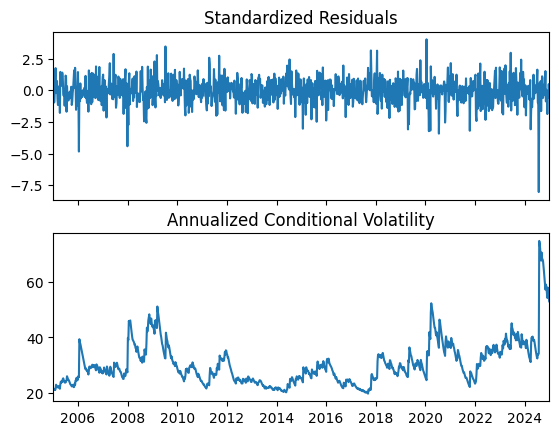

In [339]:
model_best_fit.plot(annualize='W')
plt.show()

(array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
         -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
          6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19,  20]),
 array([ 3.89614924e-03,  1.34821515e-03,  3.30712045e-03, -5.74771318e-05,
        -9.83288520e-04, -7.65146092e-04, -2.34026385e-03, -2.81237152e-03,
        -2.86451259e-03, -8.18072721e-04,  4.12543418e-04,  6.27871292e-04,
         2.09393360e-03,  6.06095083e-03,  8.71144954e-03,  1.18230317e-02,
         7.43893175e-03,  1.16712364e-02,  9.77010275e-03,  8.31637989e-03,
         3.22084978e-03, -1.34668461e-02, -1.68636621e-02, -1.47325994e-02,
        -1.38733092e-02, -1.01049036e-02, -8.15836029e-03, -7.37279826e-03,
        -5.33760975e-03, -7.84636626e-03, -7.19641673e-03, -6.33296304e-03,
         1.58868111e-03, -8.56550390e-04, -1.04812894e-03, -5.81161701e-03,
        -9.65157470e-03, -1.11185691e-02, -9.43908928e-03, -1.35042083e-02,
 

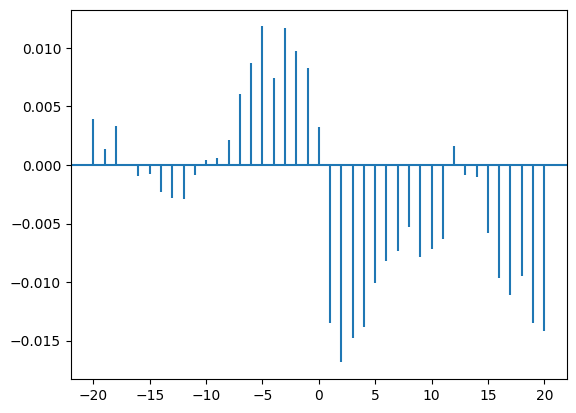

In [340]:
cond_vol = np.array(model_best_fit.conditional_volatility)[1:]
ret_arr = np.array(returns).flatten()[1:]


# plot cross-correlation function between residuals and volatility
plt.xcorr(cond_vol, ret_arr, maxlags=20)

In [341]:
import numpy as np
from scipy.stats import norm

def black_scholes(S, K, T, r, sigma, option_type="call"):
    """
    Prices a European call or put option using the Black-Scholes formula.
    
    Parameters:
    S : float : Current stock price
    K : float : Strike price
    T : float : Time to expiration (in years)
    r : float : Risk-free interest rate (annualized)
    sigma : float : Volatility of the underlying asset (annualized)
    option_type : str : "call" for call option, "put" for put option
    
    Returns:
    float : Option price
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")
    
    return price


In [353]:
model_best_fit.forecast(horizon=5, reindex=False)

# Example Usage
annualizer = 52
S = price_series["INTC"].iloc[-5]    # Current stock price
K = 21    # Strike price
T = 1/52      # Time to expiration (in years = 1 week)
r = 0.05   # Risk-free interest rate (5%)
sigma = forecast_sigma_1step*np.sqrt(annualizer)  # Annualized volatility forecast (20%)

call_price = black_scholes(S, K, T, r, sigma, option_type="call")
put_price = black_scholes(S, K, T, r, sigma, option_type="put")

print(f"European Call Option Price: {call_price:.2f}")
print(f"European Put Option Price: {put_price:.2f}")

European Call Option Price: 20.88
European Put Option Price: 20.94


In [368]:
print(price_series["INTC"].iloc[-6])
print(price_series["INTC"].iloc[-6]*1.001)
print(price_series["INTC"].iloc[-6]*0.999)

24.049999237060547
24.074049236297604
24.025949237823486


In [369]:
call_prices = []
put_prices = []
straddle_prices = []
annualizer = 52
S = price_series["INTC"].iloc[-6]    # Current stock price
K_call = 24.07    # Strike price for call
K_put = 24.02    # Strike price for put
maturities = [1/52]      # Time to expiration (in years = 1 week)
r = 0.05   # Risk-free interest rate (5%)

for mean in mean_models:
    for vol in vol_models:
        for dist in dists:
            for maturity in maturities:
                model = arch_model(returns[:-5], mean=mean, lags=1 if mean == 'AR' else 0, vol=vol, p=1, q=1, dist=dist)
                res = model.fit(disp='off')
                if vol == 'EGARCH':
                    forecast = res.forecast(horizon=5, method='simulation', simulations=500, reindex=False)
                else:
                    forecast = res.forecast(horizon=5, reindex=False)
                vol_forecast = np.sqrt(forecast.variance.values[-1, :])
                sigma = vol_forecast[-1]*np.sqrt(annualizer)
                call_prices.append({"Mean":mean, "Vol":vol, "Distr":dist, "Maturity":maturity*52, "Price":black_scholes(S, K_call, maturity, r, sigma, option_type="call")})
                put_prices.append({"Mean":mean, "Vol":vol, "Distr":dist, "Maturity":maturity*52, "Price":black_scholes(S, K_put, maturity, r, sigma, option_type="put")})
                straddle_prices.append({"Mean":mean, "Vol":vol, "Distr":dist, "Maturity":maturity*52, "Price":black_scholes(S, S, maturity, r, sigma, option_type="call") + black_scholes(S, S, maturity, r, sigma, option_type="put")})

# Create a DataFrame to hold the results
results_call = pd.DataFrame(call_prices)
results_put = pd.DataFrame(put_prices)
results_straddle = pd.DataFrame(straddle_prices)

# Print the results as a formatted table using tabulate
print(tabulate(results_call, headers='keys', tablefmt='psql', showindex=False, floatfmt='.4f'))
print(f"Current price: {S}")
print(f"Call strike: {K_call}")
print(f"Put strike: {K_put}")

+----------+--------+---------+------------+---------+
| Mean     | Vol    | Distr   |   Maturity |   Price |
|----------+--------+---------+------------+---------|
| Constant | GARCH  | normal  |     1.0000 | 24.0488 |
| Constant | GARCH  | t       |     1.0000 | 24.0445 |
| Constant | EGARCH | normal  |     1.0000 | 24.0435 |
| Constant | EGARCH | t       |     1.0000 | 23.9986 |
| AR       | GARCH  | normal  |     1.0000 | 24.0488 |
| AR       | GARCH  | t       |     1.0000 | 24.0445 |
| AR       | EGARCH | normal  |     1.0000 | 24.0441 |
| AR       | EGARCH | t       |     1.0000 | 24.0002 |
+----------+--------+---------+------------+---------+
Current price: 24.049999237060547
Call strike: 24.07
Put strike: 24.02


In [370]:

print(tabulate(results_put, headers='keys', tablefmt='psql', showindex=False, floatfmt='.4f'))

+----------+--------+---------+------------+---------+
| Mean     | Vol    | Distr   |   Maturity |   Price |
|----------+--------+---------+------------+---------|
| Constant | GARCH  | normal  |     1.0000 | 23.9957 |
| Constant | GARCH  | t       |     1.0000 | 23.9914 |
| Constant | EGARCH | normal  |     1.0000 | 23.9905 |
| Constant | EGARCH | t       |     1.0000 | 23.9456 |
| AR       | GARCH  | normal  |     1.0000 | 23.9957 |
| AR       | GARCH  | t       |     1.0000 | 23.9915 |
| AR       | EGARCH | normal  |     1.0000 | 23.9911 |
| AR       | EGARCH | t       |     1.0000 | 23.9472 |
+----------+--------+---------+------------+---------+


In [345]:

print(tabulate(results_straddle, headers='keys', tablefmt='psql', showindex=False, floatfmt='.4f'))

+----------+--------+---------+------------+---------+
| Mean     | Vol    | Distr   |   Maturity |   Price |
|----------+--------+---------+------------+---------|
| Constant | GARCH  | normal  |     1.0000 | 40.0787 |
| Constant | GARCH  | normal  |     5.0000 | 40.0038 |
| Constant | GARCH  | t       |     1.0000 | 40.0715 |
| Constant | GARCH  | t       |     5.0000 | 40.0038 |
| Constant | EGARCH | normal  |     1.0000 | 40.0702 |
| Constant | EGARCH | normal  |     5.0000 | 40.0038 |
| Constant | EGARCH | t       |     1.0000 | 40.0004 |
| Constant | EGARCH | t       |     5.0000 | 40.0038 |
| AR       | GARCH  | normal  |     1.0000 | 40.0788 |
| AR       | GARCH  | normal  |     5.0000 | 40.0038 |
| AR       | GARCH  | t       |     1.0000 | 40.0716 |
| AR       | GARCH  | t       |     5.0000 | 40.0038 |
| AR       | EGARCH | normal  |     1.0000 | 40.0710 |
| AR       | EGARCH | normal  |     5.0000 | 40.0038 |
| AR       | EGARCH | t       |     1.0000 | 40.0029 |
| AR      